# what does `NTXentLoss_poly` do? 

In [1]:
import torch, os, argparse, json, copy

import pandas as pd
import numpy as np
from termcolor import cprint

from tqdm import tqdm
from datetime import datetime
from utils import _logger, set_requires_grad
from model import *
from utils import _calc_metrics, copy_Files
from loss import * # base_Model, base_Model_F, target_classifier
from datetime import datetime

from dataloader_old import data_generator
from trainer import Trainer, model_finetune, model_test, model_pretrain
from pprint import pprint


from sklearn.metrics import (
    roc_auc_score,
    classification_report,
    confusion_matrix,
    average_precision_score,
    accuracy_score,
    precision_score,
    f1_score,
    recall_score,
)

# For Arial
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['font.family'] = "sans-serif"
matplotlib.rcParams['font.sans-serif'] = "Arial"
matplotlib.rcParams["text.usetex"] = False

# for latex:
# matplotlib.rcParams['font.family'] = "DejaVu Sans"
# matplotlib.rcParams['font.serif'] = "Computer Modern"
# matplotlib.rcParams["text.usetex"] = True

matplotlib.rcParams["lines.linewidth"] = 3
matplotlib.rcParams["xtick.direction"] = "out"
matplotlib.rcParams["ytick.direction"] = "out"
matplotlib.rcParams["axes.labelsize"] = 22
matplotlib.rcParams["xtick.labelsize"] = 22
matplotlib.rcParams["ytick.labelsize"] = 22
matplotlib.rcParams["font.size"] = 22
matplotlib.rcParams["legend.fontsize"] = 22
matplotlib.rcParams["axes.titlesize"] = 22
matplotlib.rcParams["animation.html"] = "jshtml"
matplotlib.rcParams["figure.autolayout"] = True

matplotlib.rcParams['axes.spines.right'] = False
matplotlib.rcParams['axes.spines.top'] = False


print(f'CUDA available: {torch.cuda.is_available()}')

device_count = torch.cuda.device_count()
for i in range(device_count):
    torch.cuda.set_device(i)
    cur_device_id = torch.cuda.current_device()
    cur_device_name = torch.cuda.get_device_name(cur_device_id)
    print(f'Current device:\nID {cur_device_id} | Name: {cur_device_name}')
    print(f'supported arch list: {torch.cuda.get_arch_list()}\n')
    
bar_format='{l_bar}{bar:10}{r_bar}{bar:-10b}'


CUDA available: True
Current device:
ID 0 | Name: RTX A6000
supported arch list: ['sm_37', 'sm_50', 'sm_60', 'sm_70', 'sm_75', 'sm_80', 'sm_86']

Current device:
ID 1 | Name: Quadro P2200
supported arch list: ['sm_37', 'sm_50', 'sm_60', 'sm_70', 'sm_75', 'sm_80', 'sm_86']



In [4]:
sourcedata = 'SleepEEG' # 'FD_A', 'HAR', 'ECG'
exec(f'from config_files.{sourcedata}_Configs import Config as Configs')
configs = Configs() # THis is OK???

In [11]:
device = 'cpu'

In [12]:
# Contrastive normalized temperature-scaled cross entropy loss

batch_size = 128

z_dim = 100
z_t = torch.rand(size=(128, z_dim))
z_f = torch.rand(size=(128, z_dim))

# instantiate cosine similarity function
get_cosine_similarity = torch.nn.CosineSimilarity(dim=-1) # along the axis that has the same dimensionality

conc = torch.cat([z_t, z_f], dim=0)
# conc = torch.cat([z_f], dim=0)
print(conc.shape)
similarity_matrix = get_cosine_similarity(conc.unsqueeze(1), conc.unsqueeze(0))
print(similarity_matrix.shape)

torch.Size([256, 100])
torch.Size([256, 256])


In [14]:
# Load Model 
"""Here are two models, one basemodel, another is temporal contrastive model"""

TFC_model = TFC(configs).to(device)
classifier = target_classifier(configs).to(device)

cprint(TFC_model, color='grey')
cprint(classifier, color='red')

TFC(
  (conv_block1_t): Sequential(
    (0): Conv1d(1, 32, kernel_size=(25,), stride=(3,), padding=(12,), bias=False)
    (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool1d(kernel_size=2, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Dropout(p=0.35, inplace=False)
  )
  (conv_block2_t): Sequential(
    (0): Conv1d(32, 64, kernel_size=(8,), stride=(1,), padding=(4,), bias=False)
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool1d(kernel_size=2, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (conv_block3_t): Sequential(
    (0): Conv1d(64, 128, kernel_size=(8,), stride=(1,), padding=(4,), bias=False)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool1d(kernel_size=2, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (projector_t): Sequential(
    (0):

In [15]:
# load model parameters
TFC_model.load_state_dict(torch.load('../weights/TFC_model.wts'))

<All keys matched successfully>

CPU times: user 39.5 s, sys: 4.39 s, total: 43.9 s
Wall time: 35.9 s


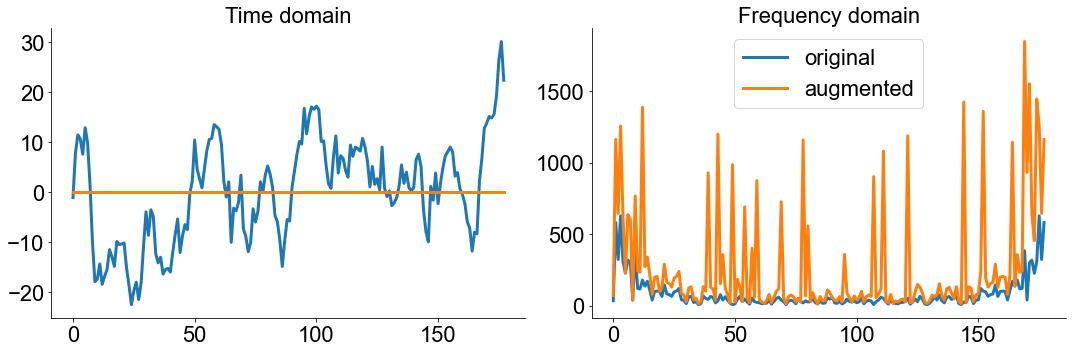

In [22]:
%%time
# inspect data visually

subset = False # use a subset for debugging.

training_mode = 'pre_train'   # 'fine_tune_test'
sourcedata = 'SleepEEG' # 'FD_A', 'HAR', 'ECG'
targetdata = 'Epilepsy'   # 'Epilepsy, 'FD_B', 'Gesture', 'EMG'
sourcedata_path = f"../datasets/{sourcedata}"
targetdata_path = f"../datasets/{targetdata}"

train_dl, valid_dl, test_dl = data_generator(sourcedata_path, targetdata_path,
                                             configs,
                                             training_mode,
                                             subset=subset)

train_dl_iter = iter(train_dl)

b = next(train_dl_iter)
# 'orig_TD', 'label', 'aug_TD', 'orig_freq', 'aug_freq'

h_t, z_t, h_f, z_f = TFC_model(b[0].to(device), b[3].to(device).float())


item_in_batch_id = 0
fig, (ax, ax1) = plt.subplots(1,2, figsize=(15,5))

item_in_batch = b[0].squeeze().numpy()[item_in_batch_id,:]
ax.plot(item_in_batch, label='original')

item_in_batch = b[2].squeeze().numpy()[item_in_batch_id,:]
ax.plot(item_in_batch, label='augmented')

item_in_batch = b[3].squeeze().numpy()[item_in_batch_id,:]
ax1.plot(item_in_batch, label='original')

item_in_batch = b[4].squeeze().numpy()[item_in_batch_id,:]
ax1.plot(item_in_batch, label='augmented')

ax.set_title('Time domain')
ax1.set_title('Frequency domain')

# ax.legend()
ax1.legend()

In [23]:
# Contrastive normalized temperature-scaled cross entropy loss

batch_size = configs.batch_size
# instantiate cosine similarity function
get_cosine_similarity = torch.nn.CosineSimilarity(dim=-1) # along the axis that has the same dimensionality

conc = torch.cat([z_t, z_f], dim=0)
# conc = torch.cat([z_f], dim=0)
print(conc.shape)
similarity_matrix = get_cosine_similarity(conc.unsqueeze(1), conc.unsqueeze(0))
print(similarity_matrix.shape)

torch.Size([256, 128])
torch.Size([256, 256])


In [24]:
conc.unsqueeze(1).shape, conc.unsqueeze(0).shape

(torch.Size([256, 1, 128]), torch.Size([1, 256, 128]))

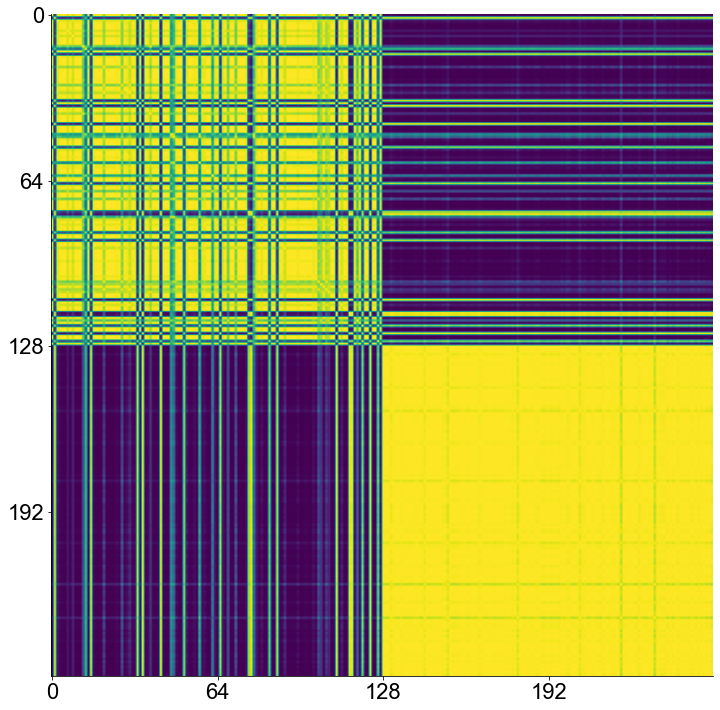

In [25]:
# this is the similarity matrix. is has 4 quadrants: TD-TD, TD-FD, FD-TD, FD-FD

fig, ax = plt.subplots(1,1, figsize=(10,10))
ax.imshow(similarity_matrix.cpu().detach().numpy())
ax.set_yticks(list(range(0, 256, int(256/4))))
_ = ax.set_xticks(list(range(0, 256, int(256/4))))

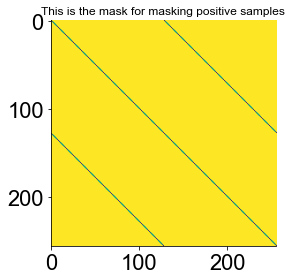

In [27]:
def _get_correlated_mask():
    diag = np.eye(2 * batch_size)
    l1 = np.eye((2 * batch_size), 2 * batch_size, k=-batch_size)
    l2 = np.eye((2 * batch_size), 2 * batch_size, k=batch_size)
    mask = torch.from_numpy((diag + l1 + l2))
    mask = (1 - mask).type(torch.bool)
    return mask.to(device)

mask_samples_from_same_repr = _get_correlated_mask().type(torch.bool)
plt.imshow(mask_samples_from_same_repr.cpu().detach().numpy())
_ = plt.title('This is the mask for masking positive samples', fontsize=12)

In [28]:
# positives are on the 128th diagonal and antidiagonal

l_pos = torch.diag(similarity_matrix, batch_size)
r_pos = torch.diag(similarity_matrix, -batch_size)
positives = torch.cat([l_pos, r_pos]).view(2 * batch_size, 1)

# negatives are everything except the diagonals (we don't care about the main diagonal either, it's always 1 no matter what)
negatives = similarity_matrix[mask_samples_from_same_repr].view(2 * batch_size, -1)

print(f'positives: {positives.shape}, negatives: {negatives.shape}')


positives: torch.Size([256, 1]), negatives: torch.Size([256, 254])


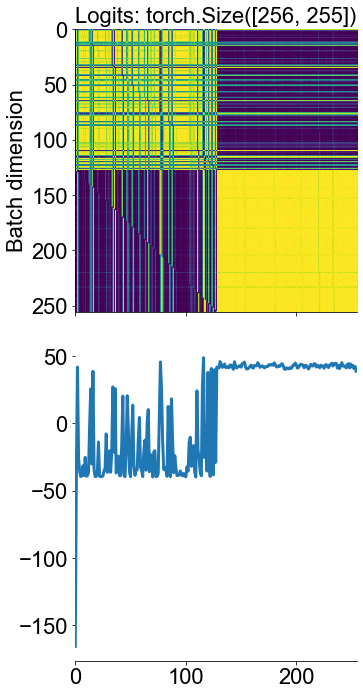

In [29]:
# the sum of the 0-th column is encouraged to be larger than in other columns
# i.e. we want positive samlple embeddings to be more similar that negative samples
# and we do so BY COMPUTING CROSSENTROPY OF EACH ELEENT IN THE BATCH 
# WITH A VECTOR WHOSE 0-TH ELEMENT IS ONE AND ALL OTHERS ARE ZEROS

fig, (ax, ax1) = plt.subplots(2, 1, figsize=(5,10), sharex=True)
logits = torch.cat((positives, negatives), dim=1)
ax.imshow(logits.cpu().detach().numpy())
ax.set_title(f'Logits: {logits.shape}')
ax.set_ylabel('Batch dimension')


ax1.plot(logits[:,].sum(axis=0).cpu().detach().numpy())
ax1.spines['left'].set_visible(False)

In [30]:

labels = torch.zeros(2 * batch_size).to(device).long()
print(f'shape of labels is {labels.shape}')
_criterion = torch.nn.CrossEntropyLoss(reduction="sum")

# zeros in labels will be internally converted by nn.CrossEntropyLoss into one-hot vectors [1, 0, ..., 0]} 
CE = _criterion(logits, labels) # is computed for every item along the batch_dim

shape of labels is torch.Size([256])


In [31]:
# poly loss is just a term in the overall Xent loss
# softmax each element in the batch, take the mean of the 0-th elements of each softmaxed element

onehot_label = torch.cat(
    (torch.ones(2 * batch_size, 1),
     torch.zeros(2 * batch_size, negatives.shape[-1])),
    dim=-1).to(device).long()

pt = torch.mean(onehot_label * torch.nn.functional.softmax(logits, dim=-1))

print(f'shape of onehot_label is {onehot_label.shape}')
epsilon = 0.2
loss = CE / (2 * batch_size) + epsilon * (1 / batch_size - pt)

shape of onehot_label is torch.Size([256, 255])


In [32]:
onehot_label

tensor([[1, 0, 0,  ..., 0, 0, 0],
        [1, 0, 0,  ..., 0, 0, 0],
        [1, 0, 0,  ..., 0, 0, 0],
        ...,
        [1, 0, 0,  ..., 0, 0, 0],
        [1, 0, 0,  ..., 0, 0, 0],
        [1, 0, 0,  ..., 0, 0, 0]])